In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.insert(0, os.path.relpath("./segment-anything"))
import segment_anything

Segment Anything custom imported


/home/andrewhealey/autodistill-seggpt/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cfg = None
dataset = None

In [3]:
import os
# set DATASET_DIRECTORY env var to "datasets/"
os.environ["DATASET_DIRECTORY"] = "datasets"

from fine_tune.configs.climbing import *

assert cfg is not None,"Must set config"
assert dataset is not None,"Must set training dataset"

loading Roboflow workspace...
loading Roboflow project...


Extracting Dataset Version Zip to datasets/Climbing-6 in coco-segmentation:: 100%|██████████| 51/51 [00:00<00:00, 2775.34it/s]


In [4]:
import torch
seed = 5
torch.manual_seed(seed)
import numpy as np
np.random.seed(seed)
import random
random.seed(seed)

In [5]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
from fine_tune.load_datasets import load_datasets

train_dataset,valid_dataset = load_datasets(cfg.data,dataset)

Selecting classes ['climbing-holds', 'floor', 'person']


In [7]:
from fine_tune.models import WrappedSamModel

sam = WrappedSamModel(cfg).to(device)
sam.predictor.model.prompt_encoder.cpu()

encoder = sam.encoder
decoder = sam.decoder
predictor = sam.predictor

warm started


In [8]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: andrewhealey (roboflow2). Use `wandb login --relogin` to force relogin


True

In [9]:
import torch

run_num = None

if run_num is not None:
    sam.load_state_dict(torch.load(f"runs/{run_num}/trainable.pt"))

In [10]:
from fine_tune.common import SamDataset,SamBoxDataset, SamPointDataset, SamNextMaskDataset, SamEverythingDataset, RandomPointDataset, SamDummyMaskDataset, SamSemSegDataset, SamComboDataset, get_max_iou_masks

import torch

from torch.utils.data import ConcatDataset

# still using singleton args b/c I might switch away from predictor
args = [predictor]
dataset_makers = {
    "sem_seg": lambda ds: SamSemSegDataset(ds,*args),
    "box": lambda ds: SamBoxDataset(ds,*args),
    "point": lambda ds: SamPointDataset(ds,*args,points_per_mask=cfg.data.points_per_mask),
    "cls": lambda ds: SamMidasBinaryClassification(ds,*args),
    "dummy": lambda ds: SamDummyMaskDataset(ds,*args),
    "everything": lambda ds: SamEverythingDataset(ds,*args,points_per_side=cfg.data.points_per_side,top_k=None),
    "random": lambda ds: RandomPointDataset(ds,*args,points_per_img=cfg.data.points_per_img),
}

def prep_datasets(ds):
    datasets = []
    for task in cfg.data.tasks:
        datasets.append(dataset_makers[task](ds))
    return SamComboDataset(datasets,*args)

curr_dataset = prep_datasets(train_dataset)
valid_curr_dataset = prep_datasets(valid_dataset)

from torch.utils.data import random_split
if cfg.data.valid_prompts is not None:
    num_prompts = len(valid_curr_dataset)

    # split off prompts
    valid_curr_dataset,_ = random_split(valid_curr_dataset,[cfg.data.valid_prompts,num_prompts-cfg.data.valid_prompts])

  0%|          | 0/31 [00:00<?, ?it/s]

100%|██████████| 8/8 [00:00<00:00, 116105.30it/s]


In [11]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


In [12]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.functional import threshold, normalize

import cv2
import numpy as np

from numpy.random import permutation
from tqdm import tqdm
import json

from persam.persam_f import calculate_sigmoid_focal_loss, calculate_dice_loss

from fine_tune.viz import mask_to_img,clip_together_imgs, show_confusion_matrix, render_prompt
from fine_tune.prompts import make_refinement_prompt


In [13]:
from PIL import Image
import numpy as np
from persam.persam_f import calculate_iou_loss, calculate_dice_loss, calculate_sigmoid_focal_loss

def evaluate():
    pred_classes = []
    gt_classes = []

    running_loss = 0.0
    running_count = 0
    for batch in tqdm(valid_curr_dataset):

        batch = SamDataset.to_device(batch,device)
        prompt_input, gt_info, gt_cls_info, imgs,sizes, prompt = batch

        use_cls = cfg.model.decoder.use_cls and gt_cls_info is not None

        with torch.no_grad():
            encoder_output = encoder.get_decoder_input(imgs,prompt)

            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
            loss = losses["loss"]

            if use_cls:
                # get pred gt class
                (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)

                _,_,_,best_cls,_ = get_max_iou_masks(gt_info["masks"],cls_binary_masks,gt_cls_info["gt_cls"],torch.arange(cfg.data.num_classes).to(device))

                pred_classes.append(pred_cls)
                gt_classes.append(best_cls)

            running_loss += loss.item()
            running_count += 1
    valid_loss = running_loss/running_count

    wandb.log({
        "valid_loss": valid_loss,
    })

    print(f"VALID - Loss: {valid_loss:.4f}")

    if len(gt_classes) > 0:
        # calculate confusion matrix
        show_confusion_matrix(gt_classes, pred_classes, class_names=valid_dataset.classes)


In [14]:
from fine_tune.optimizer import get_optimizer

optimizer,scheduler = get_optimizer(cfg,sam)

Total trainable parameters: 552803


In [15]:
from dataclasses import asdict

run = wandb.init(
    project="sam-fine-tune",
    config=asdict(cfg)
)

curr_iters = 0
accumulated_loss = 0

# track running avg of loss
recent_losses = []

curr_epoch = 0

# iter through dataset in random order
while curr_iters < cfg.train.total_steps:
    # evaluate()
    for i,idx in enumerate(tqdm(permutation(len(curr_dataset)))):

        with torch.no_grad():
            prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(curr_dataset[idx],device)
        
        use_cls_loss = gt_cls_info is not None and cfg.model.decoder.use_cls
        
        has_fresh_prompt = True
        refinements_remaining = cfg.train.num_refinement_steps

        while has_fresh_prompt:
            has_fresh_prompt = False

            encoder_output = encoder.get_decoder_input(imgs,prompt)
            low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

            gt_masks = gt_info["masks"]
            _,H,W = gt_masks.shape
            high_res_masks = F.interpolate(
                    low_res_masks,
                    (H, W),
                    mode="bilinear",
                    align_corners=False,
                )
            high_res_masks = high_res_masks.squeeze(0)
            assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

            original_size, input_size = sizes
            upscaled_masks = predictor.model.postprocess_masks(low_res_masks, input_size, original_size).squeeze(0).to(device)
            binary_masks = normalize(threshold(upscaled_masks, 0.0, 0)).to(device)[:,:,:]

            gt_binary_mask, binary_mask, iou, pred_idx, _ = get_max_iou_masks(gt_masks,binary_masks)
            pred_iou = iou_predictions[0,pred_idx]

            pred_mask = upscaled_masks[pred_idx]

            assert gt_binary_mask.shape == binary_mask.shape,f"Mismatched shapes {gt_binary_mask.shape}, {binary_mask.shape}"
            h,w = gt_binary_mask.shape

            flat_pred_mask = pred_mask.view(1,-1)
            flat_gt_binary_mask = gt_binary_mask.view(1,-1)

            focal_loss = torch.tensor(0,device=device,dtype=torch.float32)
            dice_loss = torch.tensor(0,device=device,dtype=torch.float32)
            mse_loss = torch.tensor(0,device=device,dtype=torch.float32)
            loss = torch.tensor(0,device=device,dtype=torch.float32)

            cls_focal_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_dice_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_ce_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_mse_loss = torch.tensor(0,device=device,dtype=torch.float32)
            cls_loss = torch.tensor(0,device=device,dtype=torch.float32)

            if use_cls_loss:

                cls_upscaled_masks = predictor.model.postprocess_masks(cls_low_res_masks, input_size, original_size).squeeze(0).to(device)
                cls_binary_masks = normalize(threshold(cls_upscaled_masks + 0.1, 0.0, 0)).to(device)[:,:,:]
                # print("old mask sum:",cls_upscaled_masks.sum())

                # get focal and dice loss between cls_binary_mask and closest gt mask
                gt_cls = gt_cls_info["gt_cls"]
                num_classes = cfg.data.num_classes
                inputs = [gt_masks,cls_binary_masks,gt_cls,torch.arange(num_classes).to(device)]
                # print("old inputs sums:",[x.sum() for x in inputs])
                cls_gt_binary_mask,cls_binary_mask,max_iou,best_cls,best_det = get_max_iou_masks(*inputs)
                # print("old max_iou",max_iou)

                cls_pred_mask = cls_upscaled_masks[best_cls,:,:]
                cls_pred_iou = F.sigmoid(cls_iou_predictions[0,best_cls])

                flat_cls_pred_mask = cls_pred_mask.view(1,-1)
                flat_gt_cls_binary_mask = cls_gt_binary_mask.view(1,-1)

                cls_focal_loss = calculate_sigmoid_focal_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask,should_sigmoid=True)
                cls_dice_loss = calculate_dice_loss(flat_cls_pred_mask, flat_gt_cls_binary_mask, should_sigmoid=True)

                gt_cls_logits = gt_cls_info["gt_cls_one_hot"]
                cls_ce_loss = F.cross_entropy(cls_iou_predictions[0],gt_cls_logits[best_det])
                cls_mse_loss = F.mse_loss(cls_pred_iou,max_iou)

                cls_loss += cls_ce_loss + cls_mse_loss

                if True:
                    cls_loss += cls_dice_loss + 20 * cls_focal_loss
                
                loss += cls_loss
                
            if not (use_cls_loss and True):
                focal_loss = calculate_sigmoid_focal_loss(flat_pred_mask, flat_gt_binary_mask,should_sigmoid=True)
                dice_loss = calculate_dice_loss(flat_gt_binary_mask, flat_gt_binary_mask, should_sigmoid=True)
                mse_loss = F.mse_loss(pred_iou, iou)

                loss += mse_loss
                if True:
                    loss += dice_loss + 20 * focal_loss
                
            #
            # WandB
            #
            
            old_loss_dict = {
                "loss": loss.cpu().item(),
                "focal_loss": focal_loss.cpu().item(),
                "dice_loss": dice_loss.cpu().item(),
                "mse_loss": mse_loss.cpu().item(),
                "cls_loss": cls_loss.cpu().item(),
                "cls_focal_loss": cls_focal_loss.cpu().item(),
                "cls_dice_loss": cls_dice_loss.cpu().item(),
                "cls_mse_loss": cls_mse_loss.cpu().item(),
                "cls_ce_loss": cls_ce_loss.cpu().item(),
            }

            # remove 0-valued losses -- assume they're not used
            old_loss_dict = {f"old_{k}":v for k,v in old_loss_dict.items() if v != 0}

        

            #
            # WandB
            #
            
            loss_dict = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
            loss = loss_dict["loss"]

            input_img_torch = imgs[2]
            image_embeddings= encoder_output["image_embeddings"]
            # print(f"iter {i} - img {input_img_torch.sum()}, image_embeddings {image_embeddings.sum()}, iou_predictions {iou_predictions.sum()}, upscaled_masks {upscaled_masks.sum()} loss {loss.cpu().detach().item()}")
            # raise 1

            loss_dict = {k:v.item() for k,v in loss_dict.items()}
            wandb.log({
                **loss_dict,
                **old_loss_dict,
            })

            #
            # Logging
            #

            recent_losses += [loss.item()]
            recent_losses = recent_losses[-cfg.train.log_period:]

            if curr_iters % cfg.train.eval_period == 0:
                pass

            if curr_iters % cfg.train.log_period == 0:
                print(f"Loss: {sum(recent_losses)/len(recent_losses)}")

            curr_iters += 1

            if not cfg.train.run_grad: continue

            accumulated_loss += loss
            if curr_iters % cfg.train.batch_size == 0:
                optimizer.zero_grad()
                accumulated_loss /= torch.tensor(cfg.train.batch_size,dtype=torch.float32)
                accumulated_loss.backward()
                optimizer.step()
                accumulated_loss = 0
            
            scheduler.step(curr_iters)

            #
            # Progressive refinement
            #

            if refinements_remaining > 0:

                raise NotImplementedError("Need to update this to use new training system")

                refinements_remaining -= 1

                has_fresh_prompt = True

    curr_epoch += 1

  0%|          | 0/6395 [00:00<?, ?it/s]Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  0%|          | 1/6395 [00:03<5:35:19,  3.15s/it]

Loss: 1.3012276887893677


  3%|▎         | 204/6395 [01:11<04:52, 21.16it/s] 

Loss: 1.988576922416687


  6%|▋         | 402/6395 [01:23<05:35, 17.85it/s]

Loss: 1.4052987511456012


  9%|▉         | 603/6395 [01:34<04:40, 20.62it/s]

Loss: 0.8527592767030001


 13%|█▎        | 803/6395 [01:47<04:54, 18.98it/s]

Loss: 0.5898233859241009


 16%|█▌        | 1003/6395 [01:57<04:45, 18.91it/s]

Loss: 0.6173773115500808


 19%|█▉        | 1203/6395 [02:08<04:08, 20.90it/s]

Loss: 0.3923112511076033


 22%|██▏       | 1404/6395 [02:18<04:05, 20.30it/s]

Loss: 0.46019185876473784


 25%|██▌       | 1602/6395 [02:28<04:09, 19.18it/s]

Loss: 0.4130820823088288


 28%|██▊       | 1803/6395 [02:39<03:47, 20.17it/s]

Loss: 0.37186456920579075


 31%|███▏      | 2003/6395 [02:49<03:39, 20.02it/s]

Loss: 0.3882980739884079


 34%|███▍      | 2204/6395 [03:02<03:17, 21.23it/s]

Loss: 0.3558035572431982


 38%|███▊      | 2402/6395 [03:12<03:32, 18.76it/s]

Loss: 0.37852750523015855


 41%|████      | 2603/6395 [03:25<04:19, 14.63it/s]

Loss: 0.4203586899861693


 44%|████▍     | 2803/6395 [03:36<03:24, 17.52it/s]

Loss: 0.3684070262685418


 47%|████▋     | 3003/6395 [03:47<02:45, 20.44it/s]

Loss: 0.3789076571911573


 50%|█████     | 3204/6395 [03:58<02:35, 20.46it/s]

Loss: 0.3069095966592431


 53%|█████▎    | 3402/6395 [04:08<02:32, 19.63it/s]

Loss: 0.49602367609739306


 56%|█████▋    | 3603/6395 [04:18<02:16, 20.52it/s]

Loss: 0.3323487309552729


 59%|█████▉    | 3803/6395 [04:28<02:33, 16.85it/s]

Loss: 0.3231747515127063


 63%|██████▎   | 4004/6395 [04:40<01:53, 21.11it/s]

Loss: 0.3060145824216306


 66%|██████▌   | 4202/6395 [04:50<01:48, 20.13it/s]

Loss: 0.29358266610652206


 69%|██████▉   | 4403/6395 [05:00<01:43, 19.28it/s]

Loss: 0.35691722510382534


 72%|███████▏  | 4604/6395 [05:10<01:26, 20.64it/s]

Loss: 0.2965511278249323


 75%|███████▌  | 4802/6395 [05:20<01:24, 18.82it/s]

Loss: 0.28521479602903127


 78%|███████▊  | 5003/6395 [05:31<01:07, 20.58it/s]

Loss: 0.3378710721060634


 81%|████████▏ | 5202/6395 [05:42<01:03, 18.73it/s]

Loss: 0.2884840751439333


 84%|████████▍ | 5403/6395 [05:52<00:50, 19.69it/s]

Loss: 0.29392360446974636


 88%|████████▊ | 5604/6395 [06:02<00:38, 20.71it/s]

Loss: 0.2367742571607232


 91%|█████████ | 5804/6395 [06:12<00:28, 20.89it/s]

Loss: 0.3402654680237174


 94%|█████████▍| 6002/6395 [06:22<00:20, 19.45it/s]

Loss: 0.2564792981557548


 97%|█████████▋| 6203/6395 [06:33<00:09, 20.53it/s]

Loss: 0.34028638459742067


  0%|          | 9/6395 [00:00<04:47, 22.24it/s]

Loss: 0.8111519892327488


  3%|▎         | 207/6395 [00:10<05:23, 19.14it/s]

Loss: 0.2550964921340346


  6%|▋         | 408/6395 [00:20<04:44, 21.07it/s]

Loss: 0.26822727847844363


 10%|▉         | 608/6395 [00:31<04:52, 19.81it/s]

Loss: 0.30346616128459575


 13%|█▎        | 809/6395 [00:42<04:46, 19.47it/s]

Loss: 0.28185884883627293


 16%|█▌        | 1008/6395 [00:53<05:50, 15.39it/s]

Loss: 0.26838448248803615


 19%|█▉        | 1209/6395 [01:03<04:12, 20.53it/s]

Loss: 0.25612578665837643


 22%|██▏       | 1409/6395 [01:14<04:10, 19.90it/s]

Loss: 0.2654552782140672


 25%|██▌       | 1607/6395 [01:25<04:17, 18.58it/s]

Loss: 0.21785906987264753


 28%|██▊       | 1808/6395 [01:35<03:45, 20.32it/s]

Loss: 0.272155681271106


 31%|███▏      | 2008/6395 [01:45<03:42, 19.74it/s]

Loss: 0.24980591112747788


 35%|███▍      | 2207/6395 [01:56<03:40, 19.03it/s]

Loss: 0.2629793099872768


 38%|███▊      | 2408/6395 [02:06<03:24, 19.51it/s]

Loss: 0.2739413857832551


 41%|████      | 2607/6395 [02:17<03:31, 17.89it/s]

Loss: 0.32483917897567155


 44%|████▍     | 2807/6395 [02:27<03:10, 18.84it/s]

Loss: 0.23425393933430314


 47%|████▋     | 3008/6395 [02:38<02:43, 20.77it/s]

Loss: 0.3216766530647874


 50%|█████     | 3209/6395 [02:48<03:08, 16.86it/s]

Loss: 0.2647865542769432


 53%|█████▎    | 3408/6395 [02:59<02:36, 19.05it/s]

Loss: 0.24206425061449408


 56%|█████▋    | 3608/6395 [03:09<02:31, 18.37it/s]

Loss: 0.21507195765152573


 60%|█████▉    | 3808/6395 [03:20<02:11, 19.65it/s]

Loss: 0.28228058502078057


 63%|██████▎   | 4009/6395 [03:31<01:53, 21.10it/s]

Loss: 0.2398121277615428


 66%|██████▌   | 4209/6395 [03:41<01:54, 19.15it/s]

Loss: 0.26909114833921194


 69%|██████▉   | 4409/6395 [03:52<01:51, 17.81it/s]

Loss: 0.29825440818443893


 72%|███████▏  | 4607/6395 [04:03<01:32, 19.28it/s]

Loss: 0.2828374463319778


 75%|███████▌  | 4809/6395 [04:13<01:18, 20.19it/s]

Loss: 0.242070462917909


 78%|███████▊  | 5007/6395 [04:24<01:14, 18.69it/s]

Loss: 0.25344399048015476


 81%|████████▏ | 5208/6395 [04:34<00:57, 20.62it/s]

Loss: 0.21281774137169124


 85%|████████▍ | 5409/6395 [04:44<00:48, 20.50it/s]

Loss: 0.2810451333224773


 88%|████████▊ | 5607/6395 [04:55<00:43, 17.99it/s]

Loss: 0.23449579298496245


 91%|█████████ | 5807/6395 [05:05<00:28, 20.46it/s]

Loss: 0.25238994853571056


 93%|█████████▎| 5959/6395 [05:13<00:22, 19.00it/s]


KeyboardInterrupt: 

In [16]:
from glob import glob
import os

runs_dir = "runs_new"
run_ids = [int(fname) for fname in os.listdir(runs_dir)]
highest_run = max(run_ids) if len(run_ids) > 0 else 0
run_num = highest_run + 1
export_dir = f"{runs_dir}/{run_num}"
!mkdir -p $export_dir
print(f"Run saved to {export_dir}")

from fine_tune.export import export

export(export_dir,cfg,sam)

Run saved to runs_new/4


  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [00:22<00:00,  8.97it/s]


VALID - Loss: 0.2965


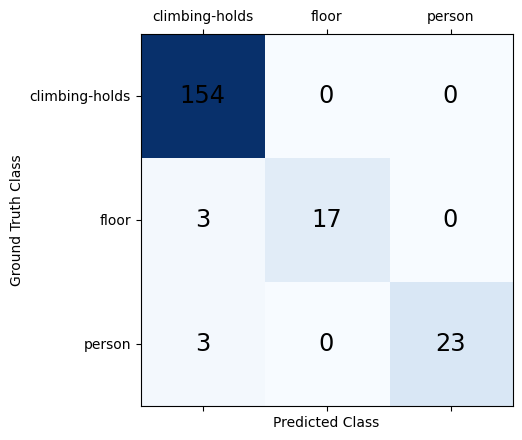

In [17]:
evaluate()

Cls loss: 0.1393047422170639
Predicted cls: 0 GT cls: 0
Predicted cls IoU: -1.1072757244110107 real cls IoU: -1.1072757244110107
binary masks:


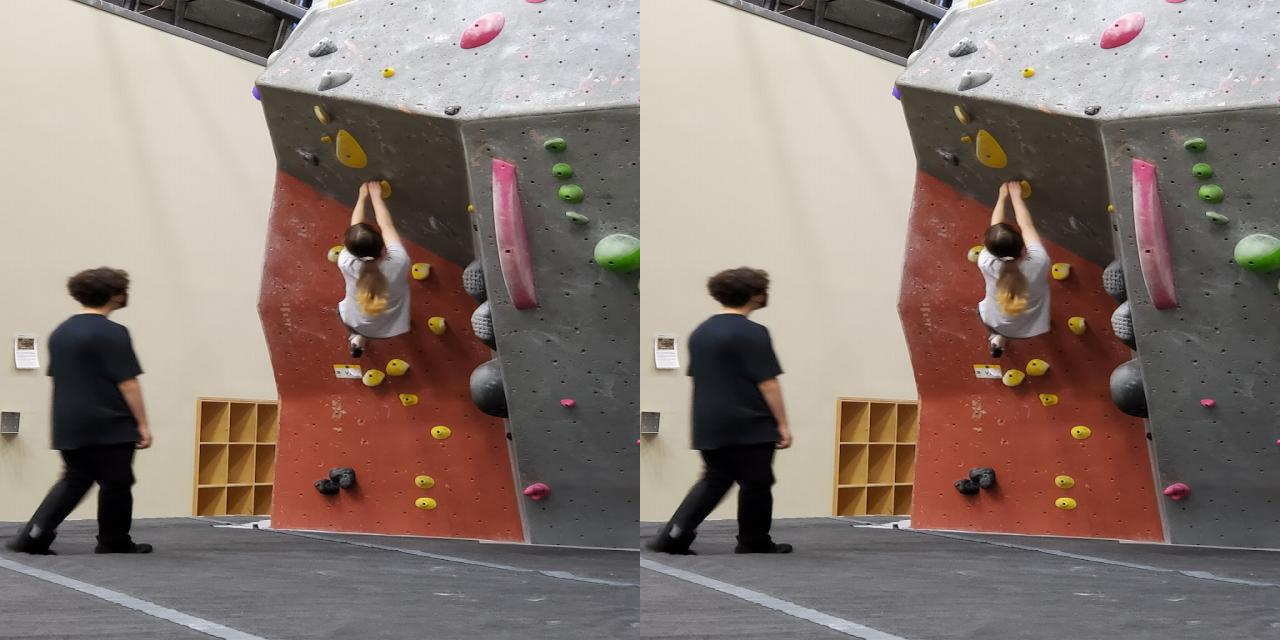

cls binary masks:


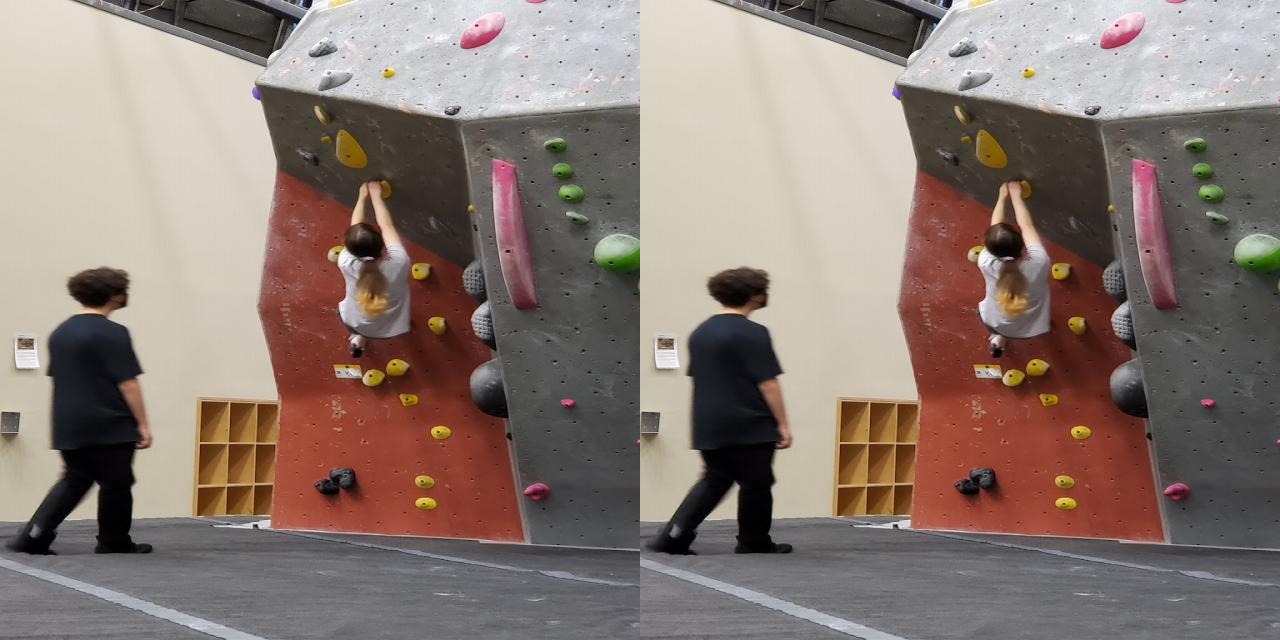

In [18]:
from random import randint

v_c_ds = valid_curr_dataset
idx = randint(0,len(v_c_ds)-1)

prompt_input, gt_info,gt_cls_info, imgs,sizes, prompt = batch = SamDataset.to_device(v_c_ds[idx],device)

gt_masks = gt_info["masks"]
gt_cls = gt_cls_info["gt_cls"]

use_cls_tokens = cfg.model.decoder.use_cls and gt_cls_info is not None

has_fresh_prompt = True
num_refinements_left = cfg.train.num_refinement_steps
while has_fresh_prompt:
    has_fresh_prompt = False

    with torch.no_grad():
        encoder_output = encoder.get_decoder_input(imgs,prompt)
        low_res_masks, iou_predictions, cls_low_res_masks,cls_iou_predictions = pred = decoder(**prompt_input,**encoder_output)

        losses = decoder.loss(*pred, gt_info,gt_cls_info, sizes,prompt)
        
        (upscaled_masks,binary_masks),max_idx = decoder.postprocess(low_res_masks,iou_predictions,sizes)
        pred_iou = iou_predictions[0,max_idx].item()
        binary_mask = binary_masks[max_idx]

        gt_binary_mask, *_ = get_max_iou_masks(gt_masks,binary_mask[None,...])

        if use_cls_tokens:

            (cls_upscaled_masks,cls_binary_masks), pred_cls = decoder.postprocess(cls_low_res_masks,cls_iou_predictions,sizes)
            cls_binary_mask = cls_binary_masks[pred_cls,...]

            # get focal and dice loss between cls_binary_mask and closest gt mask
            cls_gt_binary_mask,_,_,best_cls,_ = get_max_iou_masks(gt_masks,cls_binary_masks,gt_cls,torch.arange(cfg.data.num_classes).to(device))

        if num_refinements_left > 0:
            raise NotImplementedError("Need to update this to use new training system")

            has_fresh_prompt = True
            num_refinements_left -= 1




from PIL import Image
import numpy as np

# print cls loss
print("Cls loss:",losses["cls_loss"].item())
print("Predicted cls:",pred_cls.item(),"GT cls:",gt_cls.item())
print("Predicted cls IoU:",cls_iou_predictions[0,pred_cls].item(),"real cls IoU:",cls_iou_predictions[0,gt_cls].item())

img = imgs[0]
print("binary masks:")
clip_together_imgs(mask_to_img(binary_mask,img),mask_to_img(gt_binary_mask,img)).show()
print("cls binary masks:")
clip_together_imgs(mask_to_img(cls_binary_mask,img),mask_to_img(gt_binary_mask,img)).show()

In [ ]:
from random import choice
import fine_tune.viz

name,prompt = choice(curr_dataset.prompts)
render_prompt(name,prompt,train_dataset)

AttributeError: 'Subset' object has no attribute 'prompts'

# Segment Everything

In [ ]:
from segment_anything import SamAutomaticMaskGenerator
from segment_anything import automatic_mask_generator
from persam.load import load_predictor
import cv2

model = predictor.model
# model = load_predictor("vit_h").model.cuda()
# model.mask_decoder = mask_decoder

img = list(valid_dataset.images.values())[0]
# img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# raise NotImplementedError("TODO: fix this")

mask_generator = SamAutomaticMaskGenerator(model,stability_score_thresh=0.5,pred_iou_thresh=-0.6,points_per_side=64)
print(f"Model threshold: {model.mask_threshold}, offset: {mask_generator.stability_score_offset}")

sam_result = mask_generator.generate(img)
raw_masks = automatic_mask_generator.latest_masks

if len(sam_result) == 0:
    print("No detections found")
    raise NotImplementedError("TODO: fix this")
detections = sv.Detections.from_sam(sam_result=sam_result)

annotator = sv.MaskAnnotator()
# paste each image into the new image
# detections = pred_dataset.annotations[img_name]
tmp_img = annotator.annotate(scene=img,detections=detections)
tmp_img = Image.fromarray(tmp_img)

tmp_img

Model threshold: 0.0, offset: 1.0
iou_preds tensor(-0.5575, device='cuda:0')
iou_preds tensor(-0.5540, device='cuda:0')
iou_preds tensor(-0.5594, device='cuda:0')
iou_preds tensor(-0.5783, device='cuda:0')
iou_preds tensor(-0.6488, device='cuda:0')
iou_preds tensor(-0.6190, device='cuda:0')
iou_preds tensor(-0.6016, device='cuda:0')
iou_preds tensor(-0.5951, device='cuda:0')
iou_preds tensor(-0.5964, device='cuda:0')
iou_preds tensor(-0.5989, device='cuda:0')
iou_preds tensor(-0.6014, device='cuda:0')
iou_preds tensor(-0.6021, device='cuda:0')
iou_preds tensor(-0.5982, device='cuda:0')
iou_preds tensor(-0.5844, device='cuda:0')
iou_preds tensor(-0.5658, device='cuda:0')
iou_preds tensor(-0.5635, device='cuda:0')
iou_preds tensor(-0.5794, device='cuda:0')
iou_preds tensor(-0.6494, device='cuda:0')
iou_preds tensor(-0.6540, device='cuda:0')
iou_preds tensor(-0.6364, device='cuda:0')
iou_preds tensor(-0.6155, device='cuda:0')
iou_preds tensor(-0.6039, device='cuda:0')
iou_preds tensor(-0.

NotImplementedError: TODO: fix this

In [ ]:
from PIL import Image
import numpy as np
print(raw_masks.shape,raw_masks.dtype)
Image.fromarray(raw_masks[0].detach().cpu().numpy().astype(np.uint8) * 255)

In [ ]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "weights/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
from fine_tune.samed import LoRA_Mask_Decoder

lora_mask_decoder = LoRA_Mask_Decoder(sam.mask_decoder,r=5)

lora_mask_decoder.load_lora_parameters("lora.pt")
mask_decoder = lora_mask_decoder.mask_decoder.cuda()

In [ ]:
import cv2
img = cv2.imread("demo-img.png")#list(train_dataset.images.values())[0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

masks = mask_generator.generate(img)

masks

# Progressive mask gen

In [ ]:
import supervision as sv

class LabellingSession:
    def __init__(self,img:np.ndarray):
        self.img = img
        self.sv_dataset = sv.DetectionDataset(
            classes=train_dataset.classes,
            images={
                "test":img
            },
            annotations={
                "test":sv.Detections.empty()
            }
        )
        self.torch_dataset = SamNextMaskDataset(self.sv_dataset,predictor,device)
        self.annotator = sv.MaskAnnotator()
    
    def update_detections(self,detections:sv.Detections):
        self.sv_dataset.annotations["test"] = detections

    def img_to_tensors(self):
        return self.torch_dataset[0]
    
    def show(self):
        return Image.fromarray(self.annotator.annotate(scene=self.img,detections=self.sv_dataset.annotations["test"]))
    
    @torch.no_grad()
    def get_next_mask(self):
        decoder_input, _, (input_size,original_size), img, (unresized_img,resized_img) = self.img_to_tensors()
        H,W,_ = img.shape

        new_input = {**decoder_input}

        if vit_lora:
            sam_embedding = image_encoder(resized_img)[0]
            new_input["image_embeddings"] = sam_embedding

        if use_cnn:
            cnn_embedding = cnn_sam(unresized_img,resized_img)[0]

            curr_embedding = new_input["image_embeddings"]

            new_input["image_embeddings"] = curr_embedding + cnn_embedding

        low_res_masks, iou_predictions = mask_decoder(**new_input)

        high_res_masks = F.interpolate(
                low_res_masks,
                (H, W),
                mode="bilinear",
                align_corners=False,
            )
        high_res_masks = high_res_masks.squeeze(0)
        assert len(high_res_masks.shape) == 3,f"Shape is {high_res_masks.shape}" # 1 or 3, H, W

        assert len(iou_predictions.shape) == 1, f"IoU predictions shape is {iou_predictions.shape}"

        pred_idx = torch.argmax(iou_predictions)
        pred_mask = high_res_masks[pred_idx] > 0

        # new detection
        masks = pred_mask[None, :, :].cpu().numpy()
        class_id = 0
        new_dets = sv.Detections(
            xyxy=sv.Detections.mask_to_xyxy(masks),
            mask=masks,
            class_id=np.array([class_id]),
        )

        self.update_detections(new_dets)


In [ ]:
demo_img = cv2.imread("test.jpg")

session = LabellingSession(demo_img)

In [ ]:
session.get_next_mask()

session.show